In [1]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show
from torch import nn
from transformers import AutoConfig
import torch
from math import sqrt
import torch.nn.functional as F

E:\anaconda\envs\prac\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size #768
        num_heads = config.num_attention_heads #12
        head_dim = embed_dim // num_heads #64
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )#num_heads 만큼 어텐션 헤드 만들어줌
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)#cat함수는 concatenate를 해주는 함수 옆으로 붙여준다.
        # 12개의 헤드에서 64개가 나오니깐 12*64=768로 기존 embed_dim 차원을 복구
        x = self.output_linear(x)
        return x

In [3]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
text = "time flies like an arrow"
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs_embeds = token_emb(inputs.input_ids)
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

E:\anaconda\envs\prac\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([1, 5, 768])

In [5]:
inputs.input_ids.size(-1)

5

In [7]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0) #하삼각행렬 만드는 함수 unsqueeze는 차원 한개 추가해주는 함수 입력이 3차원이라 추가한듯?
mask[0]

tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])

In [6]:
print(torch.tril(torch.ones(seq_len, seq_len)))

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


In [10]:
query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
scores.masked_fill(mask == 0, -float("inf"))
'''
마스크 값이 0이면 -inf로 변환
소프트맥스에서 e**-inf 하면 0이므로 어텐션 가중치가 전부 0으로 변환 -> 미래 토큰을 엿보지 못하게만듬
'''

tensor([[[30.0203,    -inf,    -inf,    -inf,    -inf],
         [ 1.4904, 28.3645,    -inf,    -inf,    -inf],
         [-0.4745, -1.6242, 27.5766,    -inf,    -inf],
         [-0.2788,  0.3600, -0.6859, 24.9687,    -inf],
         [-0.4500,  1.1076, -1.0265,  1.0560, 27.7013]]],
       grad_fn=<MaskedFillBackward0>)

In [11]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

'''
앞에서 선언했던 스케일드 닷 프로덕트(그냥 내적으로 생각) 함수에 마스크를 추가함
'''

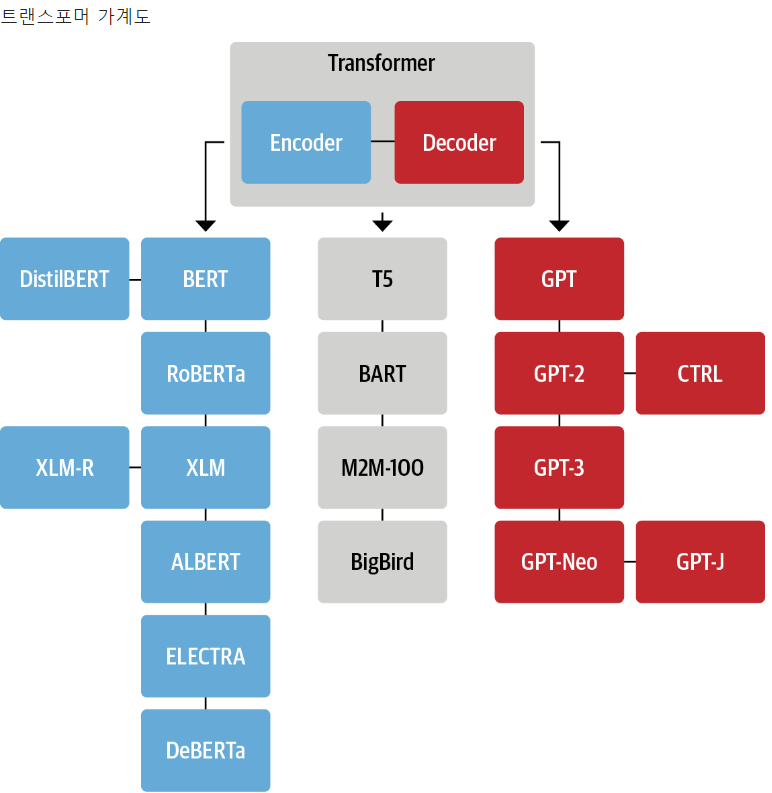

https://yerimoh.github.io/LAN18/ 상대 위치 임베딩 설명
기존에 positional embedding은 절대 위치 임베딩

# 인코더를 이용한 유명한 트랜스포머 종류  
1. BERT: 텍스트에서 마스킹된 토큰을 예측(Masked Language Modeling), 텍스트 구절이 다른 텍스트 구절 뒤에 나올 확률 판단(Next Sentence Prediction)
2. DistilBert: Bert가 커서 문제가 생김->40%적은 메모리, 60%빠른 속도 Bert에 비교해서 성능 97%보여줌, 지식정제(knowledge distillation)라는 기술 사용8
3. RoBerta: BERT의 사전 훈련 방법 수정, 더 많은 훈련데이터 더 큰 배치에서 오래 훈련 대신 NSP 사용안함 성능 크게 향상
4. XLM: GPT의 언어 모델링과 BERT의 MLM 섞음, MLM을 확장한 TLM(Translation Language Modeling) 소개-> 다중 언어 NLU에서 최상의 결과
5. XLM-RoBERTa: 이름 그대로 두개 섞음 쉽게 데이터 왕창 늘려서 학습
6. ALBERT: 토큰 임베딩 차원 감소, 파라미터 공유로 전체 파라미터 감소, NSP 목적을 문장 순서 예측으로 바꿈
7. ELECTRA: 모델 2개를 사용
   1. 원래 사용하던 MLM 학습
   2. 판별자(Discriminator):출력된 문장을 보고 마스크 토큰을 예측 ->훈련 효율 30배 증가
8. DeBERTa:
   1. 토큰을 콘텐츠용,<span style="color:red">상대위치</span> 2개로 분리해버림->셀프 어텐션 층이 인접한 토큰 쌍의 의존성을 더 잘 모델링함
   2. 단어의 절대 위치는 디코딩에서 중요함 -> 토큰 디코딩헤드의 소프트맥스 층 직전에 절대 위치 임베딩 추가 -> 최초로 사람의 성능을 추월함

* 입력 시퀀스(프롬프트): 특정한 반응이나 동작을 유도하기 위해 시스템, 특히 인공지능 모델에 제공되는 텍스트나 데이터입니다.
  프롬프트는 인공지능 모델이 이해하고 반응할 수 있도록 명확하고 구체적으로 작성하는 것이 중요합니다. 잘 작성된 프롬프트는 모델이 더 유용하고 정확한 답변을
  제공하는 데 큰 도움을 줍니다.

* 프롬프트의 예시
>* 질문형 프롬프트: "AI의 발전은 앞으로 어떻게 될까요?"
>* 명령형 프롬프트: "Python 코드로 리스트를 정렬하는 방법을 보여주세요."
>* 설명형 프롬프트: "네덜란드의 역사에 대해 설명해 주세요."







# 디코더를 이용한 유명한 트랜스포머 종류  
1. GPT: NLP에서 트랜스포머 디코더 아키텍쳐와 전이 학습을 결합. 이전 단어를 기반으로 다음 단어 예측하도록 훈련
2. GPT-2: 기존 모델에서 데이터 확장해서 학습. 긴 텍스트 시퀀스를 만듬
3. CTRL: GPT-2같은 모델은 <span style="color:red">입력 시퀀스(프롬프트)</span>의 뒤를 이음. 하지만 생성된 시퀀스 스타일은 제어못함->CTRL(Conditional Transformer Language)기술 추가
   제어 토큰을 추가함-> 생성 문장의 스타일을 제어해 다양한 문장 생성
4. GPT-3: GPT-2 성공 후 데이터를 기가막히게 늘려서 학습. 매우매우 뛰어난 성능을 가짐
5. GPT-Neo/GPT-J-6B: GPT-3가 너무 크니까 실용화 하기 위해 연구. 작은 GPT-3 성능에 견줄 만함 

# 인코더-디코더 유형
1. T5: 모든 NLU,NLG 작업을 text-to-text로 변환해 통합 따라서 seq-to-seq 문제이므로 인코더-디코터 구조를 사용. 6장에서 설명
2. BART: BERT와 GPT의 사전 훈련 과정을 결합. 입력이 마스킹,문장 섞기, 토큰 삭제, 문서 순환등 다양한 변환을 거친 후 디코더가 원본 문장을 예측.
3. M2M-100: 번역 모델은 하나의 언어 쌍과 번역 방향을 맞춰 구축되므로 확장 힘듬.(한글-> 영어 학습 했는데 다른 나라 언어 하면 주어 동사 목적어의 순서가
   다를 수 있어서 그렇다고 이해함) 하지만 접두어 토큰을 사용해 이를 해결해서 100개 언어를 번역하는 최초의 번역 모델.
4. BigBird: 트랜스포머의 기존 큰 문제는 최대 문맥 크기라는 제약점이 있음. 어텐션때문에 시퀀스 길이의 제곱으로 메모리가 필요.
   해당 논문은 메모리를 선형적으로 늘어나게 만들어 문제를 해결 따라서 기존 512 토큰을 4096으로 크게 늘려버림.